In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, count, date_format, to_timestamp, avg, stddev, udf, pandas_udf, array_contains, lit, when, size
from pyspark.sql.types import StructType, StructField, StringType, ArrayType
import pyspark.pandas as ps
import nltk
import pyspark
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import pandas as pd
import pyarrow
import sys
import os


c:\Users\pryty\anaconda3\envs\spark_env\lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [5]:
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [6]:
# Initialize Spark session

# SparkSession.getActiveSession().stop()

spark = SparkSession.builder \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
        .appName("ZipfTest").getOrCreate()

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

file_path = "Datasets/archive/Bitcoin_tweets.csv"
# Load CSV (modify options if needed)
inputDF = spark.read.csv(
    file_path, 
    header=True,  # Use the first row as column names
    inferSchema=True,  # Infer data types
    multiLine=True,  # Handle newlines within fields
    escape='"',  # Escape character for double quotes
    quote='"',  # Define the quote character

    # Different depending on the document
    sep=",",  # Specify the correct delimiter


    mode="PERMISSIVE"  # Handle malformed rows gracefully
)
inputDF.printSchema()

root
 |-- user_name: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_created: string (nullable = true)
 |-- user_followers: string (nullable = true)
 |-- user_friends: string (nullable = true)
 |-- user_favourites: string (nullable = true)
 |-- user_verified: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- source: string (nullable = true)
 |-- is_retweet: boolean (nullable = true)



In [7]:
# Change timestamp to date only
date_checkDF = inputDF.withColumn("date", date_format(to_timestamp(col("date")), "yyyy-MM-dd")) \
    .filter(col("date").isNotNull()).select("date", "text")

In [8]:
# Calculate total tweets for each day
daily_tweet_countDF = date_checkDF.groupBy("date").agg(count("*").alias("total_tweets"))

In [9]:
# daily_tweet_countDF.show()

In [10]:
# Download necessary NLTK data (only needed once)
nltk.download('punkt')
nltk.download('words')

# Build a set of English words (all in lowercase for matching)
english_vocab = set(w.lower() for w in words.words())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pryty\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\pryty\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [11]:
# Define a function to tokenize and filter tokens to only include words in the English vocabulary
@pandas_udf(ArrayType(StringType()))
def filter_english_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: [token for token in word_tokenize(text) if token.lower() in english_vocab])

In [12]:
# Assuming 'df' is your pyspark DataFrame with a column 'text'
tokenizedDF = date_checkDF.withColumn("tokenized_text", filter_english_udf(col("text")))
wordsDF = tokenizedDF.withColumn("word", explode(col("tokenized_text")))

# Count occurrences per day
word_countsDF = wordsDF.groupBy("date", "word").agg(count("*").alias("word_count"))

In [13]:
lengthDF = tokenizedDF.withColumn("length", size("tokenized_text"))

length_avgDF = lengthDF.agg(
                            avg("length").alias("avg"),
                            stddev("length").alias("dev")
                        )
# length_avgDF.show()

In [20]:
length_countsDF = lengthDF.groupBy("length").agg(count("*").alias("length_count")).cache()

+------+------------+
|length|length_count|
+------+------------+
|    31|       38922|
|    53|         321|
|    34|       34898|
|    28|       59575|
|    26|       64827|
|    27|       72254|
|    44|       11623|
|    12|      192442|
|    22|       78590|
|    47|        3924|
|     1|      122587|
|    52|         559|
|    13|      148995|
|     6|      296175|
|    16|      133950|
|     3|      211502|
|    20|       86726|
|    40|       18684|
|    57|          31|
|    54|         146|
+------+------------+
only showing top 20 rows



In [37]:
length_countsDF = length_countsDF.orderBy('length')
length_countsDF.show()

+------+------------+
|length|length_count|
+------+------------+
|     0|       33331|
|     1|      122587|
|     2|      166643|
|     3|      211502|
|     4|      213920|
|     5|      261939|
|     6|      296175|
|     7|      256514|
|     8|      269547|
|     9|      205420|
|    10|      245996|
|    11|      186151|
|    12|      192442|
|    13|      148995|
|    14|      152074|
|    15|      127267|
|    16|      133950|
|    17|      102234|
|    18|      106477|
|    19|      112629|
+------+------------+
only showing top 20 rows



In [35]:
# Convert Spark DataFrame to Pandas-on-Spark DataFrame
psdf = length_countsDF.to_pandas_on_spark()

# Set "word" as the index and select the columns to plot
df = psdf.set_index("length")["length_count"].sort_index()

c:\Users\pryty\anaconda3\envs\spark_env\lib\site-packages\pyspark\sql\dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


In [39]:
pandas_df = length_countsDF.toPandas()

# Convert the Pandas DataFrame to a NumPy array
numpy_array = pandas_df.to_numpy()

print(numpy_array)

[[     0  33331]
 [     1 122587]
 [     2 166643]
 [     3 211502]
 [     4 213920]
 [     5 261939]
 [     6 296175]
 [     7 256514]
 [     8 269547]
 [     9 205420]
 [    10 245996]
 [    11 186151]
 [    12 192442]
 [    13 148995]
 [    14 152074]
 [    15 127267]
 [    16 133950]
 [    17 102234]
 [    18 106477]
 [    19 112629]
 [    20  86726]
 [    21  89383]
 [    22  78590]
 [    23  74799]
 [    24  75966]
 [    25  68361]
 [    26  64827]
 [    27  72254]
 [    28  59575]
 [    29  50244]
 [    30  43555]
 [    31  38922]
 [    32  37492]
 [    33  35202]
 [    34  34898]
 [    35  32174]
 [    36  28659]
 [    37  25378]
 [    38  26449]
 [    39  23861]
 [    40  18684]
 [    41  16699]
 [    42  13677]
 [    43  11284]
 [    44  11623]
 [    45   7176]
 [    46   5163]
 [    47   3924]
 [    48   2630]
 [    49   1903]
 [    50   1452]
 [    51    753]
 [    52    559]
 [    53    321]
 [    54    146]
 [    55     95]
 [    56     40]
 [    57     31]
 [    58      

In [80]:
import numpy as np
from scipy.stats import gamma

# Separate the data into x values (bins) and y values (frequencies)
x = numpy_array[:, 0]
y = numpy_array[:, 1]

# Filter out the zero value to avoid fitting errors
x_positive = x[x > 0]  # Only positive bin values
y_positive = y[x > 0]  # Corresponding frequencies

# Fit a gamma distribution to the positive data
params = gamma.fit(x_positive, floc=0)  # Fix the location to 0 for the gamma distribution

# Generate values for plotting the fitted gamma distribution
x_vals = np.linspace(min(x_positive), max(x_positive), 1000)
gamma_pdf = gamma.pdf(x_vals, *params)
gamma_pdf = gamma.pdf(x_vals, a=1.86, scale=7.35)

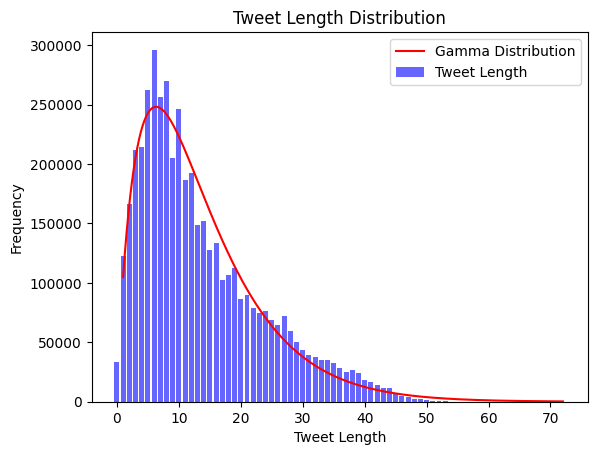

In [81]:
import matplotlib.pyplot as plt
# Plot the histogram and the fitted gamma distribution
plt.bar(x, y, width=0.8, color='blue', alpha=0.6, label='Tweet Length')
plt.plot(x_vals, gamma_pdf * np.sum(y_positive), 'r-', label='Gamma Distribution')  # Scale the PDF to match the histogram

plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Tweet Length Distribution')
plt.show()

In [13]:
df.plot.bar()

In [34]:
# # Show results
# tokenizedDF.show()
# wordsDF.show()
# word_countsDF.show()
# daily_tweet_countDF.show()

In [35]:
normalized_word_countsDF = word_countsDF.join(daily_tweet_countDF, on="date", how="right") \
    .fillna(0, subset=["word_count"]) \
    .withColumn("normalized_count", col("word_count") / col("total_tweets"))

In [36]:
normalized_word_countsDF.show()

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "c:\Users\pryty\anaconda3\envs\spark_env\lib\socket.py", line 719, in readinto
    raise
socket.timeout: timed out


In [77]:
word_statsDF = normalized_word_countsDF.groupBy("word").agg(
    avg("normalized_count").alias("avg_normalized"),
    stddev("normalized_count").alias("stddev_normalized")
)

In [ ]:
top_20_words = word_statsDF.orderBy(col("avg_normalized").desc()).limit(20).cache()

In [ ]:
top_20_words.show()

In [78]:
# Convert Spark DataFrame to Pandas-on-Spark DataFrame
psdf = word_statsDF.to_pandas_on_spark()

# Set "word" as the index and select the columns to plot
df = psdf.set_index("word")[["avg_normalized", "stddev_normalized"]].sort_values("avg_normalized", ascending=False)

# Sort by 'avg_normalized' and select top 20 words
top_20 = df.head(20)

In [79]:
top_20.plot.bar()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=avg_normalized<br>word=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'avg_normalized',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'avg_normalized',
              'orientation': 'v',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'x': array(['the', 'to', 'is', 'and', 'a', 'in', 'of', 'for', 'I', 'on', 'you',
                          'this', 'it', 'will', 'be', 'price', 'with', 'at', 'project', 'are'],
                         dtype=object),
              'xaxis': 'x',
              'y': {'bdata': ('nxUwArLV3T8ybNdTzpjXP5dV4janR9' ... '81cbQ/9mfEUllKtD8m1GADFdCzPw=='),
                    'dtype': 'f8'},
              'yaxis': 'y'},
             {'hovertemplate': 'variable=stddev_normalized<br>word=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'stddev_normalized',
              'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
              'name': 'stddev_normalized',
              'orientation': 'v',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'x': array(['the', 'to', 'is', 'and', 'a', 'in', 'of', 'for', 'I', 'on', 'you',
                          'this', 'it', 'will', 'be', 'price', 'with', 'at', 'project', 'are'],
                         dtype=object),
              'xaxis': 'x',
              'y': {'bdata': ('ddKJ6Ff/tj+uCHr9WS6vPy2ytt2Cs6' ... 'y+ZJI/8/Dnryz9sT8Hq5Hc3qyXPw=='),
                    'dtype': 'f8'},
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'word'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'value'}}}
})

In [80]:
# total = df['avg_normalized'].iloc[:100].sum()
# total_rest = df['avg_normalized'].iloc[100:].sum()

In [81]:
# Testing the assumption that the 100 first words are used 50% of the time. FALSE (or at least not that number)
# print("First 100: ", total)
# print("The rest: ", total_rest)
# print("Ratio: ", total/(total_rest+total))

In [82]:
import random

In [83]:
top_words = ["the", "to", "is", "and", "a", "in", "of", "for", "I", "on", "you", "this", "it", "will", "be"]
# top_words = df.head(20).index.tolist()

In [28]:
from pyspark.sql import functions as F
# Create a list to hold the results
random_combos = []
for i in range(20):
    random_combos.append(random.sample(top_words, 3))

# Build aggregation expressions—each combination gets an expression that counts rows where the array contains all three words.
aggregations = []
for combo in random_combos:
    # Create a condition checking that each word in the combo is in the "words" array
    condition = (
        array_contains(col("tokenized_text"), combo[0]) &
        array_contains(col("tokenized_text"), combo[1]) &
        array_contains(col("tokenized_text"), combo[2])
    )
    # Name the combination for later use (order can be kept or sorted, depending on your needs)
    combo_name = " ".join(combo)
    agg_expr = F.sum(when(condition, 1).otherwise(0)).alias(combo_name)
    aggregations.append(agg_expr)

# Perform a single aggregation over the DataFrame to get the counts for all 20 combinations at once.
# Use select() to compute the global aggregates in a single pass over the DataFrame
counts_df = tokenizedDF.select(*aggregations)

# Convert the single-row DataFrame to a dictionary and then to a Pandas DataFrame for plotting
counts_dict = counts_df.collect()[0].asDict()
plot_data = pd.DataFrame(list(counts_dict.items()), columns=['Combination', 'Count'])

In [34]:
plot_data

,Count
Combination,
on you in,23721
in the on,90467
of it this,38246
will the and,143710
will to be,95192
I on a,46145
in be I,56864
this will be,69518
be the will,126709


In [36]:
total_rows = date_checkDF.count()
total_rows

4689288

In [37]:
results = []
for triple in random_combos:
    # This retrieves the "avg" values for the words in the triple and computes their product.
    product = df.loc[triple, 'avg_normalized'].prod()
    results.append(product)

print(results) 

c:\Users\pryty\anaconda3\envs\spark_env\lib\site-packages\pyspark\pandas\generic.py:1422: FutureWarning:

Default value of `numeric_only` will be changed to `False` instead of `None` in 4.0.0.

c:\Users\pryty\anaconda3\envs\spark_env\lib\site-packages\pyspark\pandas\generic.py:1422: FutureWarning:

Default value of `numeric_only` will be changed to `False` instead of `None` in 4.0.0.

c:\Users\pryty\anaconda3\envs\spark_env\lib\site-packages\pyspark\sql\pandas\conversion.py:198: UserWarning:

toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true, but has reached the error below and can not continue. Note that 'spark.sql.execution.arrow.pyspark.fallback.enabled' does not have an effect on failures in the middle of computation.
  
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "c:\Users\pryty\anaconda3\envs\spark_env\lib\socket.py", line 719, in readinto
    r

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "c:\Users\pryty\anaconda3\envs\spark_env\lib\socket.py", line 719, in readinto
    raise
socket.timeout: timed out


In [ ]:
plot_data['multiplied_avg'] = total_rows * results

In [ ]:
plot_data.set_index("Combination", inplace=True).plot.bar()

AttributeError: 'NoneType' object has no attribute 'plot'

In [ ]:


# # Loop over each combination, filter the DataFrame, and count matching rows
# for combo in random_combos:
#     # Build the filter condition: check that the 'words' array contains each word in the combination
#     condition = lit(True)
#     for word in combo:
#         condition = condition & array_contains(col("words"), word)
    
#     # Count rows matching the condition
#     count_val = df.filter(condition).count()
    
#     # Append the combination (as a string) and its count to results
#     results.append({"combination": " ".join(combo), "count": count_val})

# # Convert the results to a Pandas DataFrame for plotting
# results_pd = pd.DataFrame(results)

# results_pd.set_index("combination", inplace=True).plot.bar()

In [ ]:
# for i in range(20):
#     word1, word2, word3 = random.sample(top_words, 3)

#     # Regular expression to check if all three words exist
#     word_and = f"(?i)(?=.*\\b{word1}\\b)(?=.*\\b{word2}\\b)(?=.*\\b{word3}\\b)"
#     word_or = f"(?i)\\b({word1}|{word2}|{word3})\\b"

#     # Filter the dataframe
#     df_filtered = df.filter(col("text").rlike(word_and))